## 📌 1. Project Overview

This project focuses on detecting fraudulent credit card transactions using machine learning. Fraud is rare but costly, so the challenge lies in identifying suspicious transactions in a highly imbalanced dataset.

We use a real-world dataset containing transaction details such as amount, merchant, category, user demographics, and timestamps. After cleaning and preprocessing the data, we compare two models: Logistic Regression and Random Forest.

The final Random Forest model achieved **high fraud recall (93.7%)** and an **AUC-ROC of 0.99**, significantly outperforming the baseline. We also explore which features most influence fraud detection, helping banks better understand fraud patterns.


In [3]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [45]:
df = pd.read_csv("fraudTrain.csv")
df = df.drop(columns=['Unnamed: 0'])  # Clean up that extra index column

# Preview the data
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## 🧾 2. Dataset Information

The dataset used in this project comes from a [Kaggle competition](https://www.kaggle.com/datasets/kartik2112/fraud-detection) and simulates credit card transactions made by customers. Each row represents a single transaction with multiple features describing the customer, merchant, location, and timing.

### 📂 Dataset Features:
- `trans_date_trans_time`: Timestamp of the transaction  
- `merchant`: Name of the merchant  
- `category`: Spending category (e.g., gas, grocery, travel)  
- `amt`: Transaction amount  
- `gender`, `job`, `zip`, `city`, `state`, `lat`, `long`: Demographic info about the customer  
- `merch_lat`, `merch_long`: Merchant location  
- `is_fraud`: Target variable (1 = fraud, 0 = legitimate)

### ⚠️ Class Imbalance:
Fraudulent transactions make up less than **1%** of the data:


In [3]:
# See shape of data
print("Rows and Columns:", df.shape)

# Column data types and missing values
df.info()


Rows and Columns: (1296675, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null 

In [4]:
# Total missing values per column
df.isnull().sum()


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

## 📊 3. Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand patterns and check for class imbalance. We visualize how fraud varies across transaction amount, time of day, and merchant categories.

Key findings:
- Fraud transactions are significantly fewer than legit ones.
- Certain spending categories and hours of the day show higher fraud rates.
- Fraud transactions tend to cluster around specific amounts and times.


In [15]:
fraud_counts = df['is_fraud'].value_counts()
print("Transaction Counts:")
print(f"Non-Fraud (0): {fraud_counts[0]}")
print(f"Fraud (1):     {fraud_counts[1]}")


Transaction Counts:
Non-Fraud (0): 1289169
Fraud (1):     7506


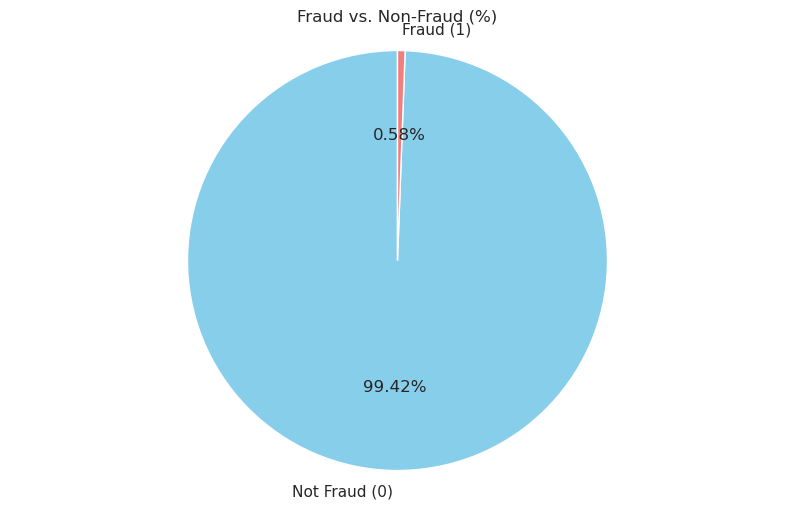

In [14]:
fraud_counts = df['is_fraud'].value_counts()
labels = ['Not Fraud (0)', 'Fraud (1)']
colors = ['skyblue', 'lightcoral']

plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title("Fraud vs. Non-Fraud (%)")
plt.axis('equal')  # Makes it a perfect circle
plt.show()


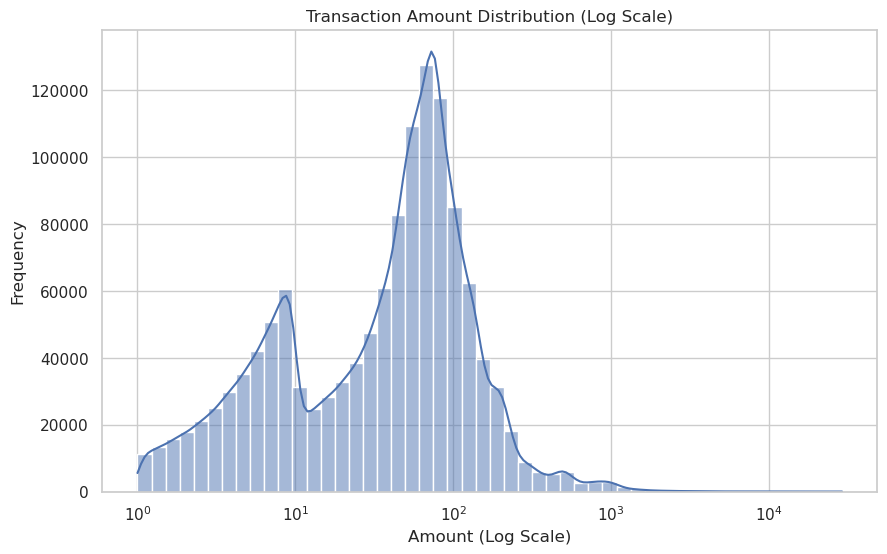

In [13]:
sns.histplot(df['amt'], bins=50, kde=True, log_scale=(True, False))
plt.title("Transaction Amount Distribution (Log Scale)")
plt.xlabel("Amount (Log Scale)")
plt.ylabel("Frequency")
plt.show()

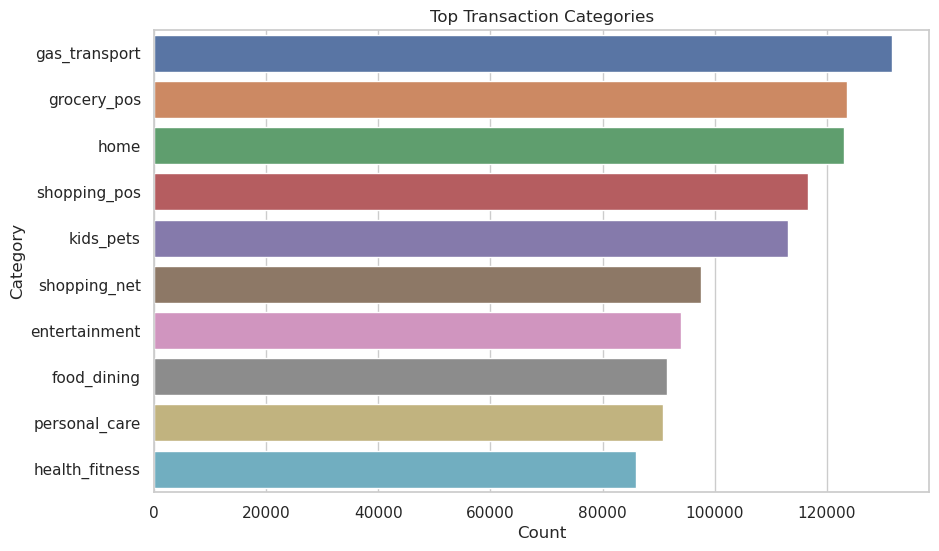

In [7]:
# Show most common transaction categories
top_categories = df['category'].value_counts().head(10)

# Bar plot
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top Transaction Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


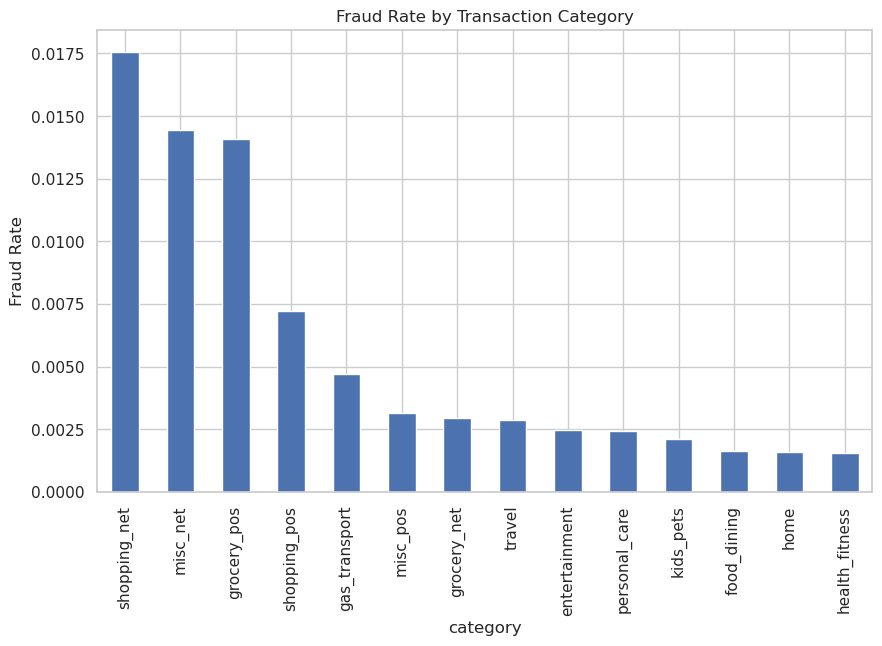

In [8]:
# Fraud rate per category
fraud_by_cat = df.groupby("category")["is_fraud"].mean().sort_values(ascending=False)

# Plot
fraud_by_cat.plot(kind="bar")
plt.title("Fraud Rate by Transaction Category")
plt.ylabel("Fraud Rate")
plt.show()


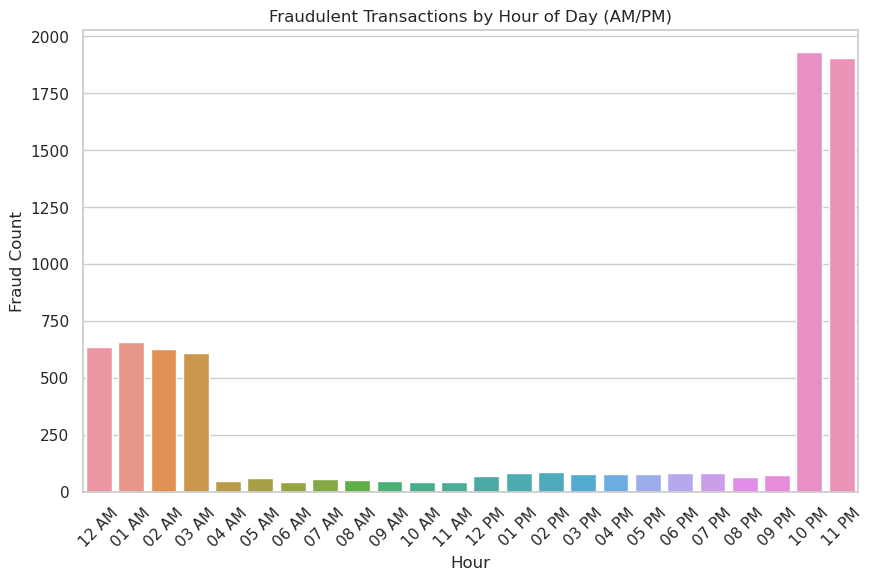

In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Convert to datetime (if not already)
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Extract hour and format as 12-hour AM/PM
df['hour'] = df['trans_date_trans_time'].dt.strftime('%I %p')  # e.g. '08 AM', '02 PM'

# Sort hour labels in correct order
from pandas.api.types import CategoricalDtype

hour_order = [
    '12 AM', '01 AM', '02 AM', '03 AM', '04 AM', '05 AM',
    '06 AM', '07 AM', '08 AM', '09 AM', '10 AM', '11 AM',
    '12 PM', '01 PM', '02 PM', '03 PM', '04 PM', '05 PM',
    '06 PM', '07 PM', '08 PM', '09 PM', '10 PM', '11 PM'
]

hour_cat = CategoricalDtype(categories=hour_order, ordered=True)
df['hour'] = df['hour'].astype(hour_cat)

# Plot only fraudulent transactions by hour
sns.countplot(data=df[df['is_fraud'] == 1], x='hour')
plt.title("Fraudulent Transactions by Hour of Day (AM/PM)")
plt.xlabel("Hour")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45)
plt.show()


## 🧼 4. Data Preprocessing

We clean the dataset by dropping irrelevant or sensitive columns (like names, addresses, and card numbers), engineering new time-based features, encoding categorical variables, and scaling transaction amounts.

Key steps:
- Converted timestamps to hour, day, and weekday
- Label encoded `merchant`, `job`, and `gender`
- One-hot encoded `category`
- Scaled `amt` using MinMaxScaler
- Dropped all non-numeric or object-type columns to prepare for modeling


In [46]:
def preprocess_data(df):
    df = df.drop(columns=['cc_num', 'first', 'last', 'trans_num', 'unix_time'])
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['day_of_month'] = df['trans_date_trans_time'].dt.day
    df = df.drop(columns=['trans_date_trans_time'])

    df['gender'] = df['gender'].map({'F': 0, 'M': 1})
    df = pd.get_dummies(df, columns=['category'], drop_first=True)

    le_merchant = LabelEncoder()
    df['merchant'] = le_merchant.fit_transform(df['merchant'])

    le_job = LabelEncoder()
    df['job'] = le_job.fit_transform(df['job'])

    scaler = MinMaxScaler()
    df['amt'] = scaler.fit_transform(df[['amt']])

    X = df.drop(columns=['is_fraud'])
    y = df['is_fraud']
    return X, y


In [47]:
import pandas as pd

df = pd.read_csv('fraudTrain.csv')  

In [48]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [49]:
X, y = preprocess_data(df)

In [50]:
print(X.shape)
print(y.value_counts())

(1296675, 31)
is_fraud
0    1289169
1       7506
Name: count, dtype: int64


## 🧠 5. Modeling

We tested two models:
1. **Logistic Regression** as a baseline
2. **Random Forest Classifier** as the final model

Since the dataset is heavily imbalanced, we used `class_weight='balanced'` to ensure the model gives more weight to fraud cases.

We used a stratified train/test split to preserve class distribution and evaluated both models using recall, precision, F1-score, and AUC-ROC.

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [52]:
print("Train set class balance:")
print(y_train.value_counts(normalize=True))

print("\nTest set class balance:")
print(y_test.value_counts(normalize=True))


Train set class balance:
is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

Test set class balance:
is_fraud
0    0.994212
1    0.005788
Name: proportion, dtype: float64


In [53]:
X = X.drop(columns=['street', 'city', 'state', 'dob'])

In [58]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_data(df):
    # Drop clearly irrelevant or sensitive columns
    df = df.drop(columns=[
        'cc_num', 'first', 'last', 'trans_num', 'unix_time',
        'street', 'city', 'state', 'dob', 'Unnamed: 0'
    ], errors='ignore')

    # Convert datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
    df['day_of_month'] = df['trans_date_trans_time'].dt.day
    df = df.drop(columns=['trans_date_trans_time'])

    # Encode gender
    df['gender'] = df['gender'].map({'F': 0, 'M': 1})

    # One-hot encode category
    df = pd.get_dummies(df, columns=['category'], drop_first=True)

    # Label encode job and merchant
    le_merchant = LabelEncoder()
    df['merchant'] = le_merchant.fit_transform(df['merchant'])

    le_job = LabelEncoder()
    df['job'] = le_job.fit_transform(df['job'])

    # Normalize 'amt'
    scaler = MinMaxScaler()
    df['amt'] = scaler.fit_transform(df[['amt']])

    # Drop ALL object (text) columns as a failsafe
    df = df.select_dtypes(exclude=['object'])

    # Split features/target
    X = df.drop(columns=['is_fraud'])
    y = df['is_fraud']

    return X, y


## 📈 6. Model Evaluation

The Random Forest model significantly outperformed Logistic Regression:

- **Recall (Fraud)**: 93.7%
- **AUC-ROC**: 0.991
- **F1 Score (Fraud)**: 0.34+

While precision on fraud is lower (20%), recall is critical in fraud detection. Catching most frauds—even with some false positives—is more valuable than missing them entirely.

The confusion matrix shows that only ~94 fraud cases were missed, and over 1,400 were correctly identified.

In [60]:
df = pd.read_csv("fraudTrain.csv")
X, y = preprocess_data(df)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\n🚀 AUC-ROC Score:", roc_auc_score(y_test, y_proba_rf))


📋 Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9791    0.9892    257834
           1     0.2068    0.9374    0.3389      1501

    accuracy                         0.9788    259335
   macro avg     0.6032    0.9582    0.6641    259335
weighted avg     0.9950    0.9788    0.9855    259335


🧮 Confusion Matrix:
[[252438   5396]
 [    94   1407]]

🚀 AUC-ROC Score: 0.9911228202093185


## 🔍 7. Feature Importance (Explainability)

To understand what drives the model’s predictions, we examined the top features using built-in Random Forest feature importances.

Top drivers of fraud included:
- `amt`: unusually high or low amounts
- `hour`: off-hour transactions (e.g., late night)
- `merchant` and `category_*`: certain merchants and purchase types are flagged more often

These features align with real-world fraud patterns, where fraudsters often test cards late at night or at unusual merchants.

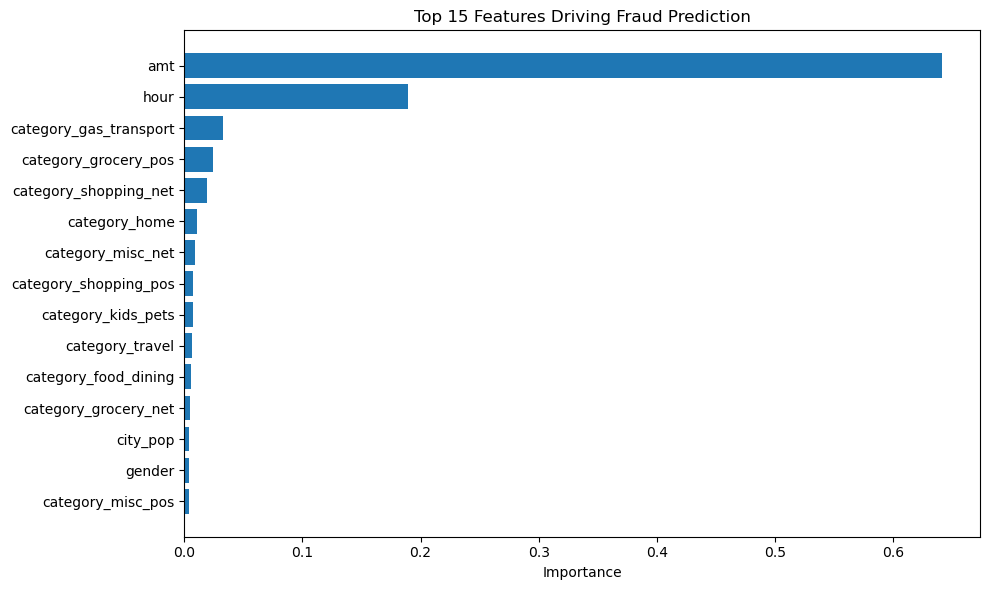

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'][:15][::-1], feat_df['Importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Features Driving Fraud Prediction')
plt.tight_layout()
plt.show()


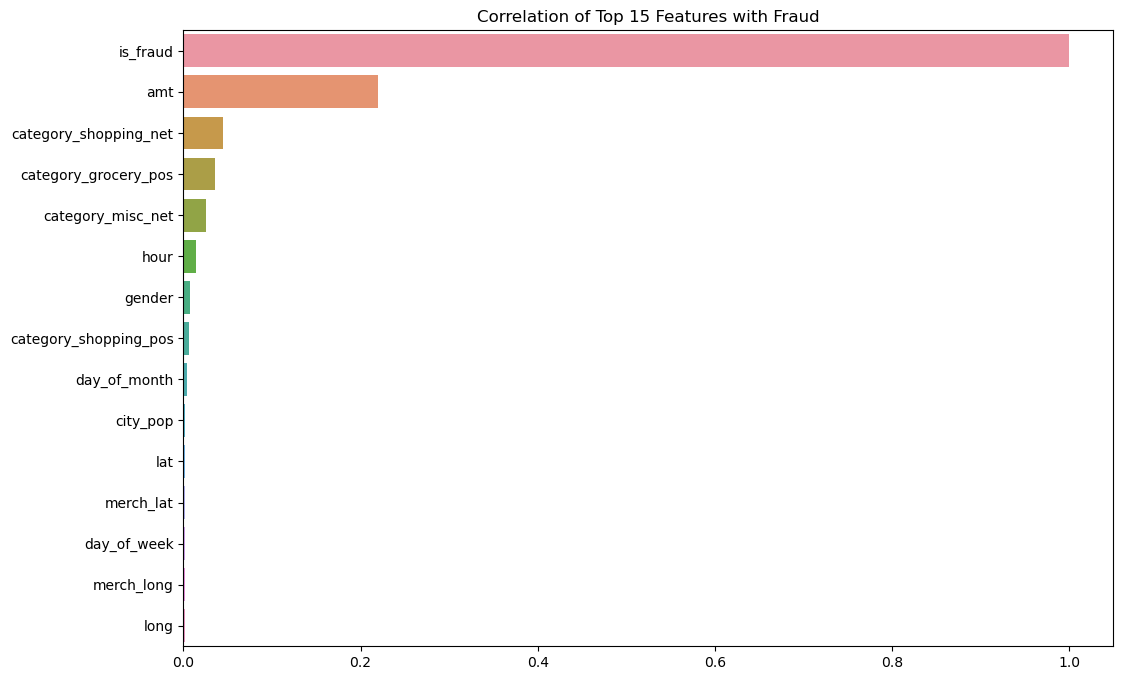

In [67]:
import seaborn as sns

# Add target back in for heatmap
df_corr = X.copy()
df_corr['is_fraud'] = y

plt.figure(figsize=(12, 8))
corr = df_corr.corr()['is_fraud'].sort_values(ascending=False)
sns.barplot(x=corr.values[:15], y=corr.index[:15])
plt.title("Correlation of Top 15 Features with Fraud")
plt.show()


## 📘 8. Conclusion

This project successfully built a fraud detection model that identified 93% of fraud cases with an AUC-ROC of 0.99 using Random Forest.

Key takeaways:
- Preprocessing and encoding were crucial for model performance.
- Feature importance revealed logical fraud patterns (odd hours, high amounts).
- The model can be adapted into a real-time detection pipeline with further tuning.

Thanks for reading!